# PyTorch starter - FasterRCNN Inference

```
********************************************************************************************
         __           _                                _       _                 _    
        / _|         | |                              | |     | |               | |   
       | |_ ___  _ __| | ___ __ ___  _   _ _ __   ___ | |_ ___| |__   ___   ___ | | __
       |  _/ _ \| '__| |/ / '_ ` _ \| | | | '_ \ / _ \| __/ _ \ '_ \ / _ \ / _ \| |/ /
       | || (_) | |  |   <| | | | | | |_| | | | | (_) | ||  __/ |_) | (_) | (_) |   < 
       |_| \___/|_|  |_|\_\_| |_| |_|\__, |_| |_|\___/ \__\___|_.__/ \___/ \___/|_|\_\
                                      __/ |                                           
                                     |___/                                    
********************************************************************************************
                    If you'd like to publish a forked version of this notebook,
                            please do not remove this notice.
--------------------------------------------------------------------------------------------
                                      Original Notebook
--------------------------------------------------------------------------------------------
Title...............: VinBigData FasterRCNN Pytorch - Inference
Link................: https://kaggle.com/pestipeti/vinbigdata-fasterrcnn-pytorch-inference
Author..............: Peter (https://kaggle.com/pestipeti)
Version.............: 8


--------------------------------------------------------------------------------------------
                                          Fork #1                   
--------------------------------------------------------------------------------------------
Title...............: [Your notebook's title]
```


You can find the [train notebook here](https://www.kaggle.com/pestipeti/vinbigdata-fasterrcnn-pytorch-train)

- FasterRCNN from torchvision
- Uses Resnet50+FPN backbone
- Original Dicom Images (resized to 512)

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision
import tqdm

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

DIR_INPUT = 'C:/A/lesionData/data'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'
DIR_WEIGHTS = 'C:/A/lesionData/data_coco/weights/save_weights_2800'

WEIGHTS_FILE = f'{DIR_WEIGHTS}/model_state_epoch_1.pth'

c:\Users\wew12\Anaconda3\envs\pytorch110_p38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# test_df 전체 데이터 정보 불러오기

test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
test_df
# classID confidence xmin ymin xmax ymax

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y
0,test_200000.json,0,0,0,0,0,0,0,0,0,0
1,test_200001.json,0,0,0,0,0,0,0,0,0,0
2,test_200002.json,0,0,0,0,0,0,0,0,0,0
3,test_200003.json,0,0,0,0,0,0,0,0,0,0
4,test_200004.json,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
20869,test_220869.json,0,0,0,0,0,0,0,0,0,0
20870,test_220870.json,0,0,0,0,0,0,0,0,0,0
20871,test_220871.json,0,0,0,0,0,0,0,0,0,0
20872,test_220872.json,0,0,0,0,0,0,0,0,0,0


In [3]:
image_id_list=[]
file_name_list=[]
for i,k in enumerate(test_df.iloc):
    id=k['file_name'].split('.json')[0].split('test_')[1]
    image_id_list.append(id)
    file_name_list.append('test_'+id+'.jpg')
    

In [4]:
test_df['image_id']=image_id_list
test_df['file_name']=file_name_list

In [5]:
test_df

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y,image_id
0,test_200000.jpg,0,0,0,0,0,0,0,0,0,0,200000
1,test_200001.jpg,0,0,0,0,0,0,0,0,0,0,200001
2,test_200002.jpg,0,0,0,0,0,0,0,0,0,0,200002
3,test_200003.jpg,0,0,0,0,0,0,0,0,0,0,200003
4,test_200004.jpg,0,0,0,0,0,0,0,0,0,0,200004
...,...,...,...,...,...,...,...,...,...,...,...,...
20869,test_220869.jpg,0,0,0,0,0,0,0,0,0,0,220869
20870,test_220870.jpg,0,0,0,0,0,0,0,0,0,0,220870
20871,test_220871.jpg,0,0,0,0,0,0,0,0,0,0,220871
20872,test_220872.jpg,0,0,0,0,0,0,0,0,0,0,220872


In [6]:
test_df = test_df.iloc[0:2000]
test_df

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y,image_id
0,test_200000.jpg,0,0,0,0,0,0,0,0,0,0,200000
1,test_200001.jpg,0,0,0,0,0,0,0,0,0,0,200001
2,test_200002.jpg,0,0,0,0,0,0,0,0,0,0,200002
3,test_200003.jpg,0,0,0,0,0,0,0,0,0,0,200003
4,test_200004.jpg,0,0,0,0,0,0,0,0,0,0,200004
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,test_201995.jpg,0,0,0,0,0,0,0,0,0,0,201995
1996,test_201996.jpg,0,0,0,0,0,0,0,0,0,0,201996
1997,test_201997.jpg,0,0,0,0,0,0,0,0,0,0,201997
1998,test_201998.jpg,0,0,0,0,0,0,0,0,0,0,201998


# vinBigDataset

In [7]:
image_ids = test_df['image_id'].unique()

In [8]:
class LesionDataset(Dataset):
    # 초기화
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe["image_id"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    # 인덱스를 인자로 받아 훈련(혹은, 검증)에서 사용할 샘플 데이터 튜플을 반환하는 메소드
    # 샘플과 레이블(정수인덱스)로 이루어진 아이템 반환
    def __getitem__(self, index):
        
        image_id = self.image_ids[index]
        records = self.df[(self.df['image_id'] == image_id)]
        records = records.reset_index(drop=True)
        
        #image_type=self.image_dir.split('/')[-1]
        #image_id = str(image_id)
        
        img_dir = self.image_dir
        img_fn = records['file_name'][0]

        image = Image.open(img_dir+'/'+img_fn).convert('RGB')
  
        # image는 np.array입니다. 물론 height, width, layer로 되어 있는 조금 복잡한 구조
        # 따라서 이 np.array를 변환하면, 이미지 또한 변합니다. 
        # img.transpose(1, 0, 2)는 원래 height, width, layer -> width, height, layer
        
        #image = np.stack([image, image, image])
        image = np.array(image)
        image = image.astype('float32')
        image = image - image.min()
        image = image / image.max()
        image = image * 255.0
        #image = image.transpose(2,1,0)
    
        # 이미지를 파이토치 텐서로 변환 torchvision.transforms
        # img 뿐만 아니라 bounding box, label 모두 tensor 형태로 바꿔야 한다.
        if self.transforms :
            # image, bboxes라는 key값 자체가 있기 때문에 반드시 이름을 이와 같게 해야 한다.
            sample = {
                'image': image
            }
            sample = self.transforms(**sample)
            image = sample['image']    
            
        return image, image_id
    # 데이터셋의 아이템수
    def __len__(self):
        return self.image_ids.shape[0]

In [9]:
# Albumentations
def get_test_transform():
    return A.Compose([
        # FasterRCNN will normalize.
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        # ToTesorV2는 ToTensor와 마찬가지로 tensor형변환, channel dimension을 첫번째 차원으로 가져오는 역할을 하지만 min_max scaling은 하지 않는다는 것을 명심하자.
        ToTensorV2(p=1.0)
    ])

In [10]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=False,
    pretrained_backbone=False,
    min_size=512,
    max_size=853
)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# no finding 포함 15개 클래스
num_classes = 5

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE, map_location=device))
# nn.Module에서 train time과 eval time에서 수행하는 다른 작업을 수행할 수 있도록 switching 하는 함수라고 한다.
# .eval() 함수는 evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수인 셈이다.
# model.eval()의 역할은 약간 다르다. 현재(2019년) 시점에서는 모델링 시 training과 inference시에 다르게 동작하는 layer들이 존재한다. 예를 들면, Dropout layer는 학습시에는 동작해야하지만, inference시에는 동작하지 않는 것과 같은 예시를 들 수 있다. BatchNorm같은 경우도 마찬가지다.
#사실상 model.eval()는 이런 layer들의 동작을 inference(eval) mode로 바꿔준다는 목적으로 사용된다. 따라서, 우리가 보통 원하는 모델의 동작을 위해서는 위의 두 가지를 모두 사용해야하는 것이 맞다.
model.eval()
# 모델에 사용되는 모든 입력 Tensor들에 대해 input = input.to(device) 을 호출해야 합니다.
x = model.to(device)

In [12]:
test_df

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y,image_id
0,test_200000.jpg,0,0,0,0,0,0,0,0,0,0,200000
1,test_200001.jpg,0,0,0,0,0,0,0,0,0,0,200001
2,test_200002.jpg,0,0,0,0,0,0,0,0,0,0,200002
3,test_200003.jpg,0,0,0,0,0,0,0,0,0,0,200003
4,test_200004.jpg,0,0,0,0,0,0,0,0,0,0,200004
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,test_201995.jpg,0,0,0,0,0,0,0,0,0,0,201995
1996,test_201996.jpg,0,0,0,0,0,0,0,0,0,0,201996
1997,test_201997.jpg,0,0,0,0,0,0,0,0,0,0,201997
1998,test_201998.jpg,0,0,0,0,0,0,0,0,0,0,201998


In [13]:
DIR_INPUT = 'C:/A/lesionData/data_coco'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'


In [14]:
# batch sampler 로 묶인 이후에는, collate_fn을 호출해 batch로 묶는다.
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = LesionDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    collate_fn=collate_fn
)

In [45]:

detection_threshold = 0.5

results = {
    'file_name':[], 'class_id':[], 'confidence':[], 'point1_x':[], 'point1_y':[],
    'point2_x':[], 'point2_y':[], 'point3_x':[], 'point3_y':[], 'point4_x':[], 'point4_y':[]
    }

# Pytorch는 autograd engine을 꺼버린다. 
# 이 말은 더 이상 자동으로 gradient를 트래킹하지 않는다는 말
# 주된 목적은 autograd를 끔으로써 메모리 사용량을 줄이고 연산 속도를 높히기 위함이다.
# 그래서 일반적으로 inference를 진행할 때는 torch.no_grad() with statement로 감싼다는 사실을 알면 된다.
try:
    with torch.no_grad():
        for images, image_ids in test_data_loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)
            
            for i, image in enumerate(images):

                image_id = image_ids[i]


                boxes = outputs[i]['boxes'].data.cpu().numpy()
                labels = outputs[i]['labels'].data.cpu().numpy()
                scores = outputs[i]['scores'].data.cpu().numpy()

                if len(boxes) > 0:
                    # 0.5 보다 confidence 높은걸로 선택함
                    selected = scores >= detection_threshold
                    boxes = boxes[selected].astype(np.int32)
                    scores = scores[selected]
                    labels = labels[selected]
                    # 0.5 보다 confidence 높은 박스가 있다는 의미
                    for target in zip(labels,scores,boxes):
                        if len(boxes) > 0:    
                            results['file_name'].append(image_id)
                            results['class_id'].append(target[0])
                            results['confidence'].append(target[1])
                            results['point1_x'].append(target[2][0]) #x_min)
                            results['point1_y'].append(target[2][1]) #y_min)
                            results['point2_x'].append(target[2][2]) #x_max)
                            results['point2_y'].append(target[2][1]) #y_min)
                            results['point3_x'].append(target[2][2]) #x_max)
                            results['point3_y'].append(target[2][3]) #y_max)
                            results['point4_x'].append(target[2][0]) #x_min)
                            results['point4_y'].append(target[2][3]) #y_max)
                # result list를 계속 append!
                # results.append(result)
except ValueError as e:
    print(e)
    print(image_id)

In [56]:
test_df = pd.DataFrame(results) #, columns=['image_id', 'PredictionString'])
test_df

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y
0,200000,2,0.660564,21,57,550,57,550,560,21,560
1,200000,2,0.534950,217,161,545,161,545,531,217,531
2,200001,2,0.694373,44,263,333,263,333,531,44,531
3,200002,2,0.820366,216,342,331,342,331,477,216,477
4,200003,2,0.906899,115,3,281,3,281,221,115,221
...,...,...,...,...,...,...,...,...,...,...,...
2794,201996,2,0.803027,102,142,210,142,210,281,102,281
2795,201996,2,0.761368,54,188,130,188,130,277,54,277
2796,201997,2,0.675537,210,443,307,443,307,534,210,534
2797,201999,1,0.865989,337,51,473,51,473,163,337,163


In [57]:
file_name_list=[]
for i,k in enumerate(test_df.iloc):
    file_name_list.append('test_'+k['file_name']+'.json')
test_df['file_name'] =file_name_list    

In [58]:
test_df

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y
0,test_200000.json,2,0.660564,21,57,550,57,550,560,21,560
1,test_200000.json,2,0.534950,217,161,545,161,545,531,217,531
2,test_200001.json,2,0.694373,44,263,333,263,333,531,44,531
3,test_200002.json,2,0.820366,216,342,331,342,331,477,216,477
4,test_200003.json,2,0.906899,115,3,281,3,281,221,115,221
...,...,...,...,...,...,...,...,...,...,...,...
2794,test_201996.json,2,0.803027,102,142,210,142,210,281,102,281
2795,test_201996.json,2,0.761368,54,188,130,188,130,277,54,277
2796,test_201997.json,2,0.675537,210,443,307,443,307,534,210,534
2797,test_201999.json,1,0.865989,337,51,473,51,473,163,337,163


In [59]:
test_df.to_csv('C:/A/lesionData/data/submission.csv', index=False)

# sample

In [48]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


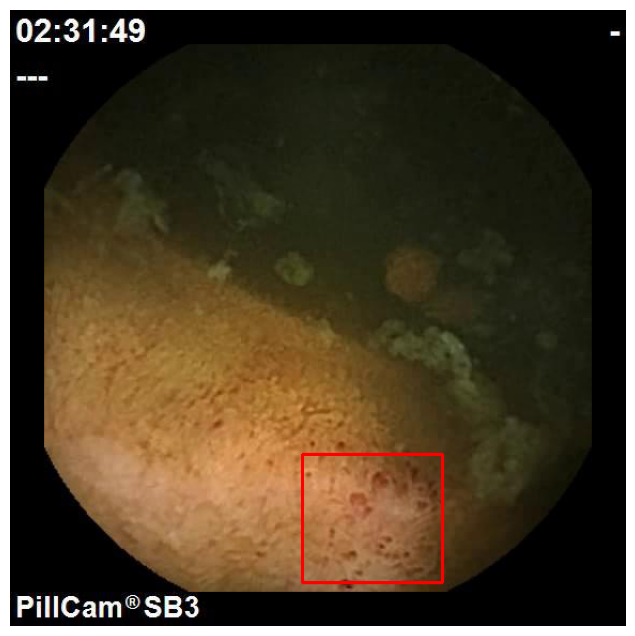

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)